In [1]:
# Imports libraries for data processing, visualization, and modeling
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Rescaling, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np
import os

2025-06-06 01:52:26.782522: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749174746.978353      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749174747.036873      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Sets image size, batch size, autotune, and class names for the classification task
IMAGE_SIZE = (100, 100)
BATCH_SIZE = 32

AUTOTUNE = tf.data.AUTOTUNE

CLASS_NAMES = ['Healthy', 'Sick']

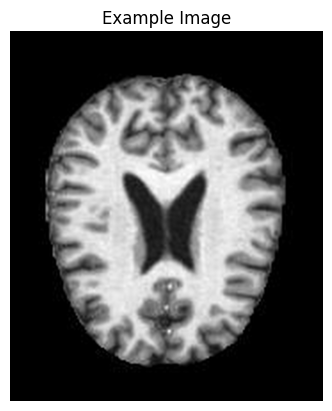

In [3]:
# Displays an example image from the training set
example_image_path = '/kaggle/input/alzheimers-dataset-early-stage-vs-health/Processed Dataset/training/Non Demented/26 (100).jpg'
img = Image.open(example_image_path)

plt.imshow(np.asarray(img))
plt.title("Example Image")
plt.axis("off")

plt.show()

In [4]:
# Loads and prepares training, validation, and test datasets with prefetching for performance
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/alzheimers-dataset-early-stage-vs-health/Processed Dataset/training",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/alzheimers-dataset-early-stage-vs-health/Processed Dataset/validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/alzheimers-dataset-early-stage-vs-health/Processed Dataset/test",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Found 9792 files belonging to 2 classes.
Using 7834 files for training.


I0000 00:00:1749174772.326046      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 4347 files belonging to 2 classes.
Found 1088 files belonging to 2 classes.


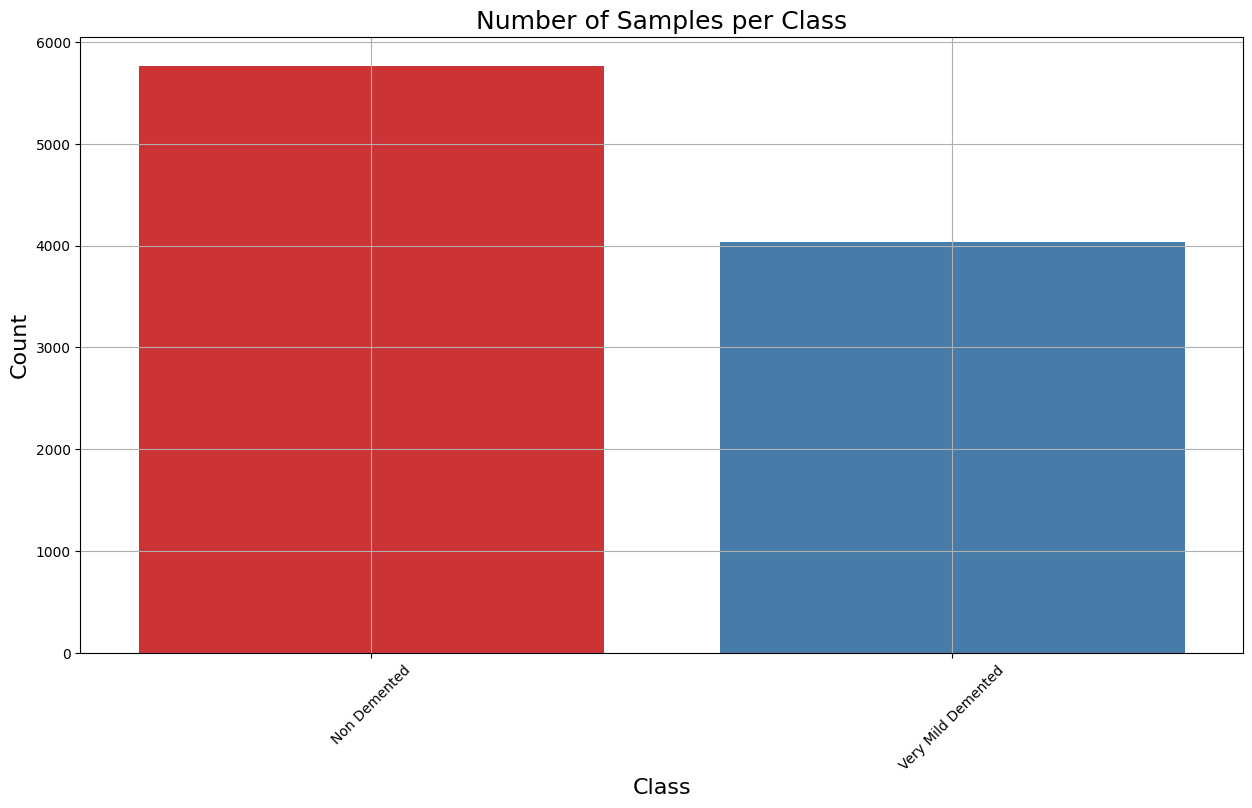

In [5]:
# Shows class distribution in the training set
train_dir = "/kaggle/input/alzheimers-dataset-early-stage-vs-health/Processed Dataset/training"

class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in os.listdir(train_dir)}

df = pd.DataFrame(list(class_counts.items()), columns=["Class", "Count"])

plt.figure(figsize=(15,8))
ax = sns.barplot(x=df["Class"], y=df["Count"], palette="Set1")
ax.set_xlabel("Class", fontsize=16)
ax.set_ylabel("Count", fontsize=16)
plt.title("Number of Samples per Class", fontsize=18)
plt.xticks(rotation=45)
plt.grid(True)

plt.show()

In [ ]:
# Defines, compiles, and summarizes a CNN model for binary image classification
model = keras.Sequential([
    Rescaling(1./255, input_shape=(100, 100, 3)),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.5),

    Dense(2, activation='softmax')  # 2 clases: Healthy, Sick
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 98, 98, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 47, 47, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,634 (397.01 KB)

 Trainable params: 101,634 (397.01 KB)

 Non-trainable params: 0 (0.00 B)

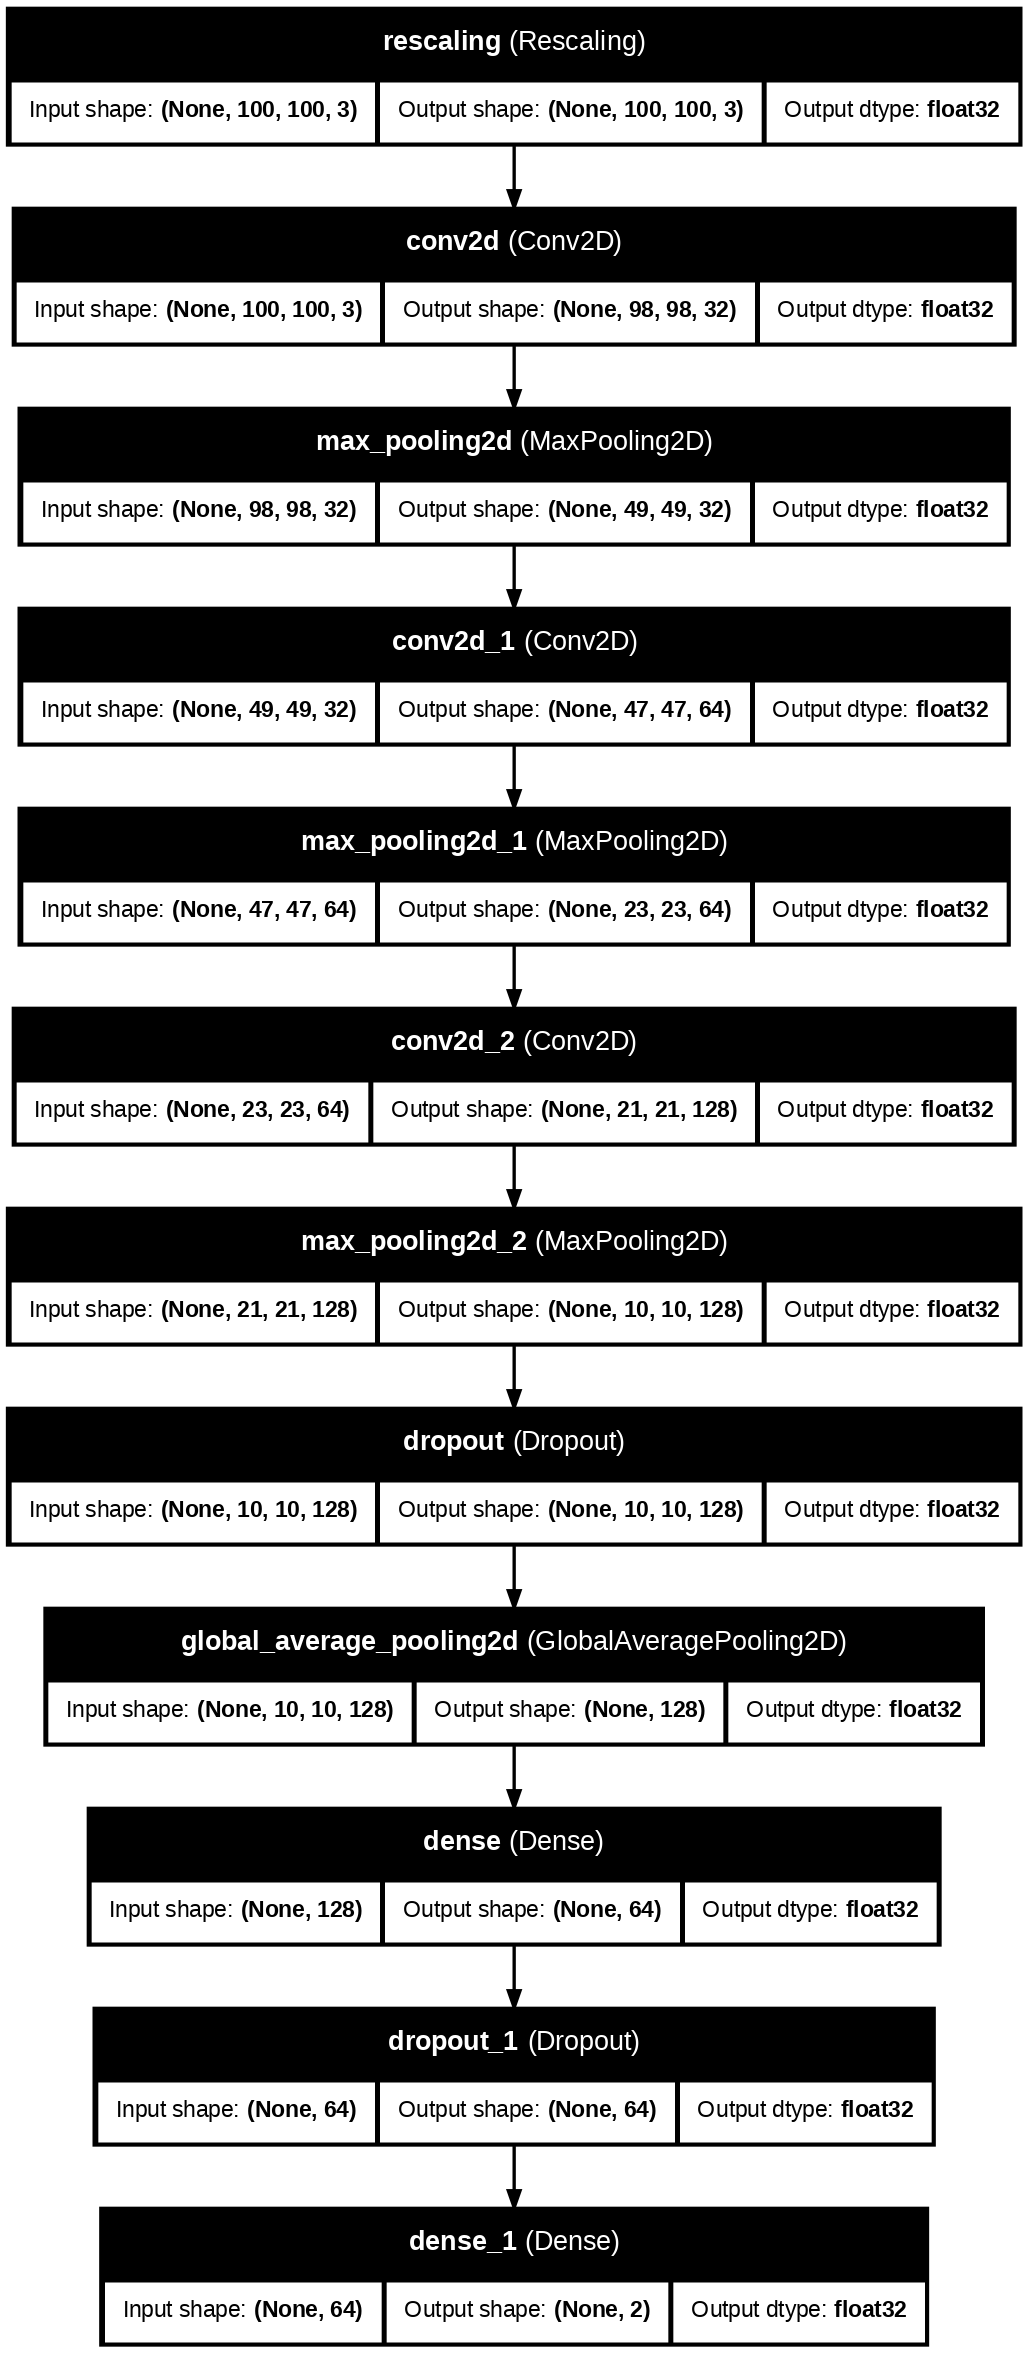

In [7]:
# Compiles the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

# Prints the model architecture summary
model.summary()

# Plots and saves the model architecture diagram to 'model.png'
keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, show_dtype=True, dpi=120)

In [8]:
# Sets up callbacks and trains the model with early stopping, checkpointing, and learning rate reduction
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5, verbose=1)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=200,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

Epoch 1/200


I0000 00:00:1749174782.261169      87 service.cc:148] XLA service 0x7c3e180044b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749174782.262085      87 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749174782.730169      87 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/245 ━━━━━━━━━━━━━━━━━━━━ 25:33 6s/step - accuracy: 0.3438 - loss: 0.7159

I0000 00:00:1749174785.992074      87 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.5890 - loss: 0.6807
Epoch 1: val_accuracy improved from -inf to 0.59029, saving model to best_model.keras
245/245 ━━━━━━━━━━━━━━━━━━━━ 89s 337ms/step - accuracy: 0.5890 - loss: 0.6807 - val_accuracy: 0.5903 - val_loss: 0.6710 - learning_rate: 0.0010
Epoch 2/200
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.5981 - loss: 0.6608
Epoch 2: val_accuracy improved from 0.59029 to 0.67886, saving model to best_model.keras
245/245 ━━━━━━━━━━━━━━━━━━━━ 74s 304ms/step - accuracy: 0.5982 - loss: 0.6608 - val_accuracy: 0.6789 - val_loss: 0.6194 - learning_rate: 0.0010
Epoch 3/200
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.6616 - loss: 0.6216
Epoch 3: val_accuracy improved from 0.67886 to 0.69496, saving model to best_model.keras
245/245 ━━━━━━━━━━━━━━━━━━━━ 74s 301ms/step - accuracy: 0.6616 - loss: 0.6215 - val_accuracy: 0.6950 - val_loss: 0.6023 - learning_rate: 0.0010
Epoch 4/200
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms

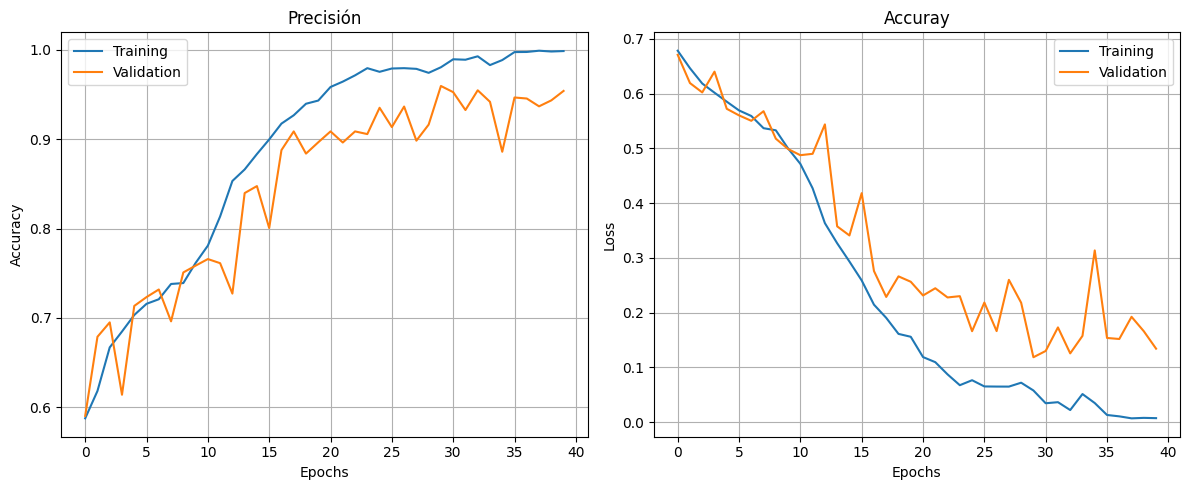

In [9]:
# Plots training and validation accuracy and loss curves after model training
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Precisión")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Accuray")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━

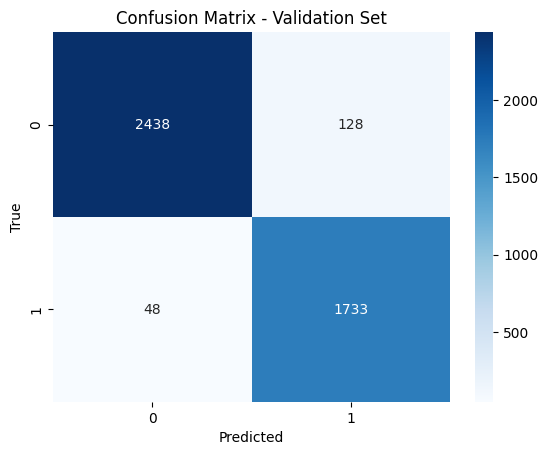

              precision    recall  f1-score   support

     Healthy     0.9807    0.9501    0.9652      2566
        Sick     0.9312    0.9730    0.9517      1781

    accuracy                         0.9595      4347
   macro avg     0.9560    0.9616    0.9584      4347
weighted avg     0.9604    0.9595    0.9596      4347

34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step
Predictions: ['99.40%', '0.60%'] -> Predicted class: Healthy (Class 0), Actual Label: Healthy
Correct ✅

Predictions: ['99.95%', '0.05%'] -> Predicted class: Healthy (Class 0), Actual Label: Healthy
Correct ✅

Predictions: ['99.93%', '0.07%'] -> Predicted class: Healthy (Class 0), Actual Label: Healthy
Correct ✅

Predictions: ['99.95%', '0.05%'] -> Predicted class: Healthy (Class 0), Actual Label: Healthy
Correct ✅

Predictions: ['99.99%', '0.01%'] -> Predicted class: Healthy (Class 0), Actual Label: Healthy
Correct ✅

Predictions: ['0.06%', '99.94%'] -> Predicted class: Sick (Class 1), Actual Label: Sick
Correct ✅

Predicti

In [10]:
# Evaluates model on validation and test sets, prints classification reports, and displays confusion matrices
y_pred, y_true = [], []

for x_batch, y_batch in val_ds:
    preds = model.predict(x_batch)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(y_batch.numpy(), axis=1))

cf_matrix = confusion_matrix(y_true, y_pred)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Validation Set")
plt.show()

print(classification_report(y_true, y_pred, digits=4, target_names=CLASS_NAMES))

predictions = model.predict(test_ds)
y_pred_test = np.argmax(predictions, axis=1)
y_real_test = np.concatenate([y for x, y in test_ds], axis=0)
y_real_test = np.argmax(y_real_test, axis=1)

for p, l in zip(predictions, y_real_test):
    probs_percent = [f"{prob*100:.2f}%" for prob in p]
    predicted_class_idx = np.argmax(p)
    predicted_class_name = CLASS_NAMES[predicted_class_idx]

    print(f"Predictions: {probs_percent} -> Predicted class: {predicted_class_name} (Class {predicted_class_idx}), Actual Label: {CLASS_NAMES[l]}")
    print("Correct ✅\n" if predicted_class_idx == l else "Incorrect ❌\n")

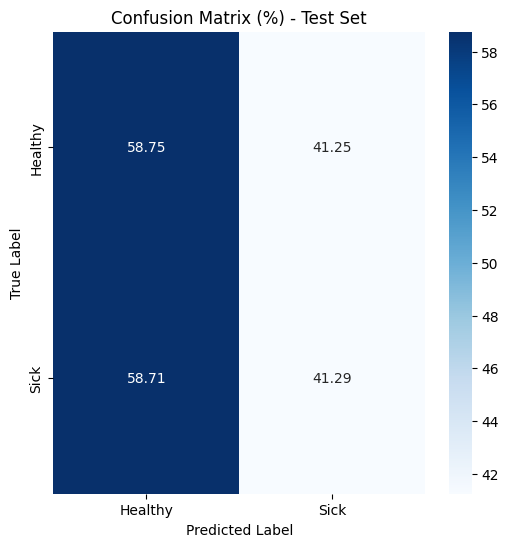

In [11]:
# Plots confusion matrix for the test set
cm_test = confusion_matrix(y_real_test, y_pred_test)

cm_percent = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6,6))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (%) - Test Set")

plt.show()